In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("us_retail_sales.csv")
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


The dataset has one row per year, and a column for each month, so reshaping it so that it has a row per month/year will make it much easier to analyze.  Pandas has a `.melt()` function that can reshape the wider format into a longer format.  We can also change the 3-letter format for month names into a number that will be easier to plot later.

In [6]:
df = df.melt(id_vars=['YEAR'], var_name='Month', value_name='sales')
months = {
    'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6,
    'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12
}

In [7]:
df['month_num'] = df['Month'].map(months)
df['date'] = pd.to_datetime(dict(year=df['YEAR'], month=df['month_num'], day=1))
df = df.sort_values('date').set_index('date')
df = df[['sales']]

In [8]:
df.head()

,sales
date,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


I don't think there is any missing data, but we can drop any missing values just in case

In [9]:
df = df.dropna()
df.head()

,sales
date,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0


Now we can plot the data and observe any general trends or any unusual outliers

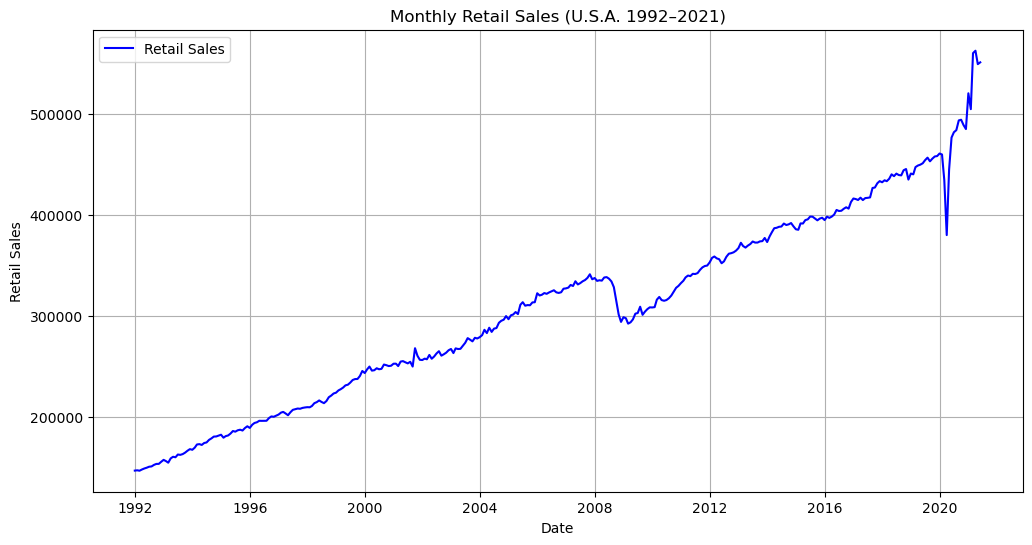

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['sales'], label='Retail Sales', color='blue')
plt.title('Monthly Retail Sales (U.S.A. 1992–2021)')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.grid(True)
plt.show()

There is a consistent upward trend in the data, except for a two irregularies that correlate with large external events  (2008, during a recession, and 2020, at the beginning of COVID).

I started building a model with SARIMA, which is a fairly typical place to start.  I chose to use auto-AIRMA, since that can help me find the best SARIMA parameters.

In [11]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from math import sqrt

You can't just willy-nilly split time series data because order matters.  Per the assignment instructions, I'll use the last year of data as the test set and the rest as my training set.  There's a technique called walk-ahead validation I'd like to experiment with later if time allows.

In [12]:
train = df.loc[:'2020-06']   # everything up to June 2020
test  = df.loc['2020-07':]   # July 2020 – June 2021

Now fit the model using SARIMA, asking auto arima to choose the best performing parameters

In [22]:
auto_model = pm.auto_arima(
    train['sales'],
    seasonal=True,
    m=12,  #12 months per year
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6888.728, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6892.499, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6892.619, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6895.872, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=6890.620, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=6890.610, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6892.598, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6890.613, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6890.751, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6892.014, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.165 seconds


Now try to forecast for the test period

In [23]:
sarima_forecast = auto_model.predict(n_periods=len(test))
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

Then evaluate the model's accuracy

In [15]:
sarima_rmse = sqrt(mean_squared_error(test['sales'], sarima_forecast))
print(f"SARIMA (Auto) RMSE: {sarima_rmse:,.2f}")

SARIMA (Auto) RMSE: 42,328.87


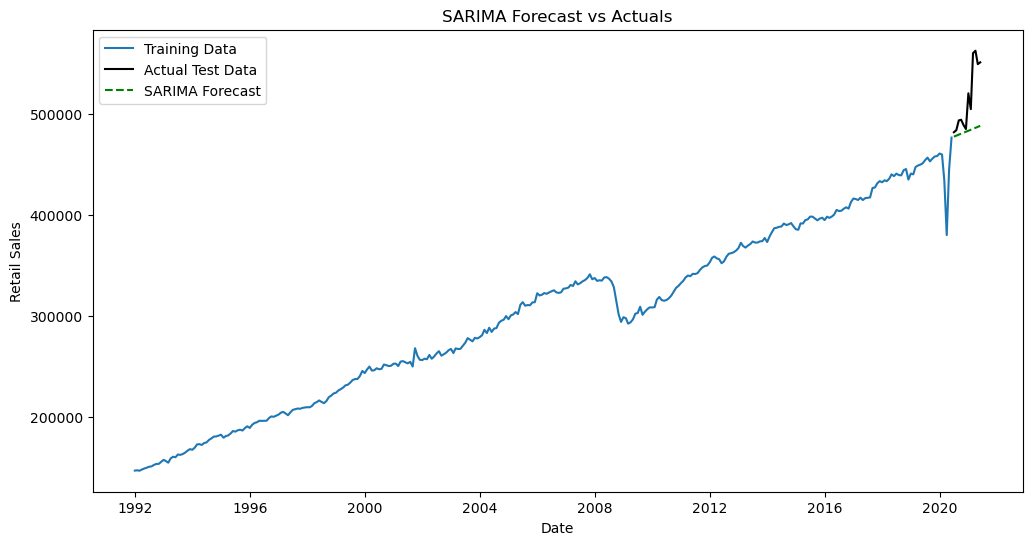

In [16]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['sales'], label='Training Data')
plt.plot(test.index, test['sales'], label='Actual Test Data', color='black')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.show()

Interesting that the SARIMA model shows a somewhat linear increase in sales in 2020, which is very different from the actual. This highlights the incredibly atypical nature of the pandemic's affect on retail sales.

Bonus comparison:  I wanted to use Holt-Winters because it helps to deal well with seasonality (which is very common in retail sales), and the HW model includes both long-term growth, regular fluctuations, and random noise in the algorithm.  Given the highly unusual nature of COVID, I don't expect the model to perform any better, but it'll be a fun experiment.

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(
    train['sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

In [18]:
hw_forecast = hw_model.forecast(len(test))

hw_rmse = sqrt(mean_squared_error(test['sales'], hw_forecast))

In [19]:
print(f"Holt-Winters RMSE: {hw_rmse:,.2f}")
print(f"Auto-SARIMA RMSE: {sarima_rmse:,.2f}")

Holt-Winters RMSE: 45,156.97
Auto-SARIMA RMSE: 42,328.87


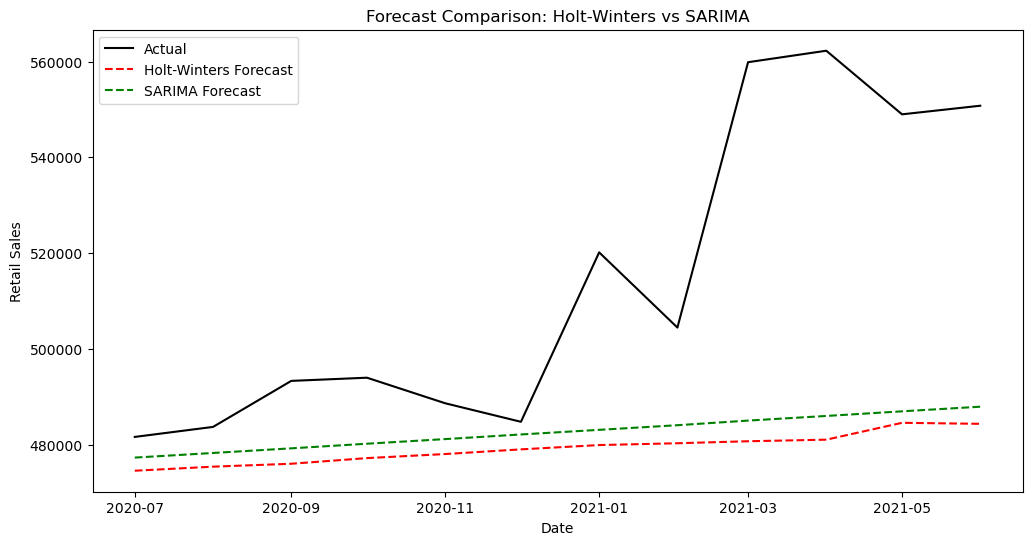

In [20]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test['sales'], label='Actual', color='black')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('Forecast Comparison: Holt-Winters vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.show()

Both models continue the linear increase and totally miss the rapid increase after the pandemic.  Both models have a really high RSME, which highlights that models don't always capture irregular events that break historical trends or patterns. The models were trained on pre-pandemic data, so both were expecting the long-term growth to continue. Since the pandemic caused worldwide lockdowns and massive deviations in normal retail behavior, the models just weren't able to accurately predict sales post-pandemic.  There's nothing wrong with the modeling approaches, it's just that COVID was a real-world disruption that couldn't have been predicted accurately.